In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import numpy as np
import scanpy as sc
from anndata import read_h5ad
from anndata import AnnData
import scipy as sp
import scipy.stats
from gprofiler import GProfiler
import pickle
from adjustText import adjust_text
from matplotlib import gridspec
# Other specific functions 
from itertools import product
from statsmodels.stats.multitest import multipletests
import time
import os

import sys
sys.path.insert(1, '../')
import util

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

-----
anndata     0.7.4
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 8.0.1
adjustText          NA
anndata             0.7.4
autoreload          NA
backcall            0.1.0
certifi             2020.11.08
cffi                1.13.1
chardet             3.0.4
cloudpickle         1.2.2
cycler              0.10.0
cython_runtime      NA
dask                2.6.0
dateutil            2.8.0
decorator           4.4.0
get_version         2.1
gprofiler           1.0.0
h5py                2.9.0
idna                2.8
igraph              0.8.3
importlib_metadata  0.23
ipykernel           5.1.2
ipython_genutils    0.2.0
ipywidgets          7.5.1
jedi                0.15.1
joblib              0.14.0
kiwisolver          1.1.0
legacy_api_wrap     1.2
leidenalg           0.8.2
llvmlite            0.31.0
louvain             0.6.1
matplotlib          3.3.2
more_itertools      NA
mpl_toolkits        NA
natsort             7.0.1
numba               0.48.0
numexpr             2.7.1
numpy    

In [2]:
# Would tissue-cell type with more category-specific aging genes be
# more likely to show this heterogenous aging state pattern? 
temp_df = pd.read_excel('/n/groups/price/martin/tms_gene_data/result_v1/tms_gene_table/tms_gene_table.xlsx')
temp_df.sum(axis=0)

gene                                              0610007C21Rik0610007N19Rik0610009D07Rik0610012...
global_aging                                                                                    330
spec_celltype:B cell                                                                             90
spec_celltype:basal cell of epidermis                                                           249
spec_celltype:endothelial cell                                                                   45
spec_celltype:macrophage                                                                          6
spec_celltype:mesenchymal stem cell                                                             174
spec_celltype:mesenchymal stem cell of adipose                                                   98
spec_celltype:myeloid cell                                                                       38
spec_celltype:skeletal muscle satellite cell                                                    249


In [2]:
# GLOBAL VARIABLES
DATA_PATH = '/n/groups/price/martin/tms_gene_data'
DGE_RES_PATH = DATA_PATH + '/DGE_result'
DGE_RES_PATH_OLD = DATA_PATH + '/DE_result_old'
ANNO_DATA_PATH = DATA_PATH + '/annotation_data'
RESULT_PATH = DATA_PATH + '/result_v1'

METHOD_LIST = ['facs', 'droplet']
DIC_METHOD_NAME = {'facs':'FACS', 'droplet':'droplet'}
CELLCATE_LIST = ['immune', 'stem cell/progenitor', 'stromal', 'endothelial', 'epithelial', 'parenchymal']

### Load data

In [3]:
# Load the data obs df: facs
temp_data = util.load_normalized_data(DATA_PATH, data_name='facs', total_ct_per_cell=1e4,
                                      flag_size_factor=False, flag_log1p=False)
gene_list_facs = list(temp_data.var_names)
gene_list_facs.sort()
temp_data.obs['n_genes'] = (temp_data.X>0).sum(axis=1)
df_obs_facs = temp_data.obs.copy()
df_obs_facs['analyte'] = ['%s.%s'%(x,y) for x,y in zip(df_obs_facs['tissue'],
                                                       df_obs_facs['cell_ontology_class'])]

# Load the data obs df: droplet
temp_data = util.load_normalized_data(DATA_PATH, data_name='droplet',
                                      flag_size_factor=False, flag_log1p=False)
gene_list_droplet = list(temp_data.var_names)
gene_list_droplet.sort()
temp_data.obs['n_genes'] = (temp_data.X>0).sum(axis=1)
df_obs_droplet = temp_data.obs.copy()
df_obs_droplet['analyte'] = ['%s.%s'%(x,y) for x,y in zip(df_obs_droplet['tissue'], 
                                                          df_obs_droplet['cell_ontology_class'])]

# Load the data obs df: bulk
temp_data = util.load_normalized_data_bulk(DATA_PATH, flag_size_factor=False, flag_log1p=False)
gene_list_bulk = list(temp_data.var_names)
gene_list_bulk.sort()
temp_data.obs['n_genes'] = (temp_data.X>0).sum(axis=1)
df_obs_bulk = temp_data.obs.copy()
df_obs_bulk['analyte'] = df_obs_bulk['tissue']

# dic for obs
dic_obs = {'facs':df_obs_facs, 'droplet':df_obs_droplet, 'bulk':df_obs_bulk}
dic_gene_list = {'facs':gene_list_facs, 'droplet':gene_list_droplet, 'bulk':gene_list_bulk}

# del temp results
del temp_data

/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.
/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.


### Load DGE results, age, tissue.cell_type, some annotations

In [4]:
# Load DGE results
df_info_facs,dic_dge_facs = util.load_DGE_res(DATA_PATH, dname='facs.tc',version='1e4')
df_info_droplet,dic_dge_droplet = util.load_DGE_res(DATA_PATH, dname='droplet.tc',version='1e4')

# Change analyte name
temp_list = list(dic_dge_facs.keys())
for analyte in temp_list:
    tissue,cell_type = analyte.split('.')
    cell_type = cell_type.replace('_', ' ')
    dic_dge_facs['%s.%s'%(tissue,cell_type)] = dic_dge_facs[analyte].copy()
    if '%s.%s'%(tissue,cell_type) != analyte: del dic_dge_facs[analyte]

temp_list = list(dic_dge_droplet.keys())
for analyte in temp_list:
    tissue,cell_type = analyte.split('.')
    cell_type = cell_type.replace('_', ' ')
    dic_dge_droplet['%s.%s'%(tissue,cell_type)] = dic_dge_droplet[analyte].copy()
    if '%s.%s'%(tissue,cell_type) != analyte:  del dic_dge_droplet[analyte]
        
# fixit: update bh_p (not sure if this is necessary)
dic_dge = {'facs':dic_dge_facs, 'droplet':dic_dge_droplet}

# Append tissue-level results
df_info_facs_tissue,dic_dge['facs.tissue'] = util.load_DGE_res(DATA_PATH, dname='facs.tissue', version='1e4')
df_info_droplet_tissue,dic_dge['droplet.tissue'] = util.load_DGE_res(DATA_PATH, dname='droplet.tissue',
                                                                     version='1e4')
df_info_bulk_tissue,dic_dge['bulk.tissue'] = util.load_DGE_res(DATA_PATH, dname='bulk.tissue', version='1e4')

In [5]:
# dic_analysis_list and dic_fdr_threshold

# analysis list: facs
min_cell_number = 100
ind_select = (df_info_facs['n_cell_young']>min_cell_number) & (df_info_facs['n_cell_old']>min_cell_number)
analysis_list_facs = list(df_info_facs.index[ind_select])

# analysis list: droplet
min_cell_number = 500
ind_select = (df_info_droplet['n_cell_young']>min_cell_number) & (df_info_droplet['n_cell_old']>min_cell_number)
analysis_list_droplet = list(df_info_droplet.index[ind_select])

dic_analysis_list = {'facs':analysis_list_facs, 'droplet':analysis_list_droplet}
for method in METHOD_LIST:
    print('%s, n_tc=%d'%(method, len(dic_analysis_list[method])))

# thresholds parameters
coef_threshold = 0.005
dic_fdr_threshold = {'facs':0.01, 'droplet':0.01, 'bulk':0.1}

facs, n_tc=76
droplet, n_tc=26


In [6]:
# Structured DGE results
dic_H_p = {}
dic_H_fdr = {}
dic_coef = {}
dic_coef_z = {}
dic_coef_se = {}
dic_coef_p = {}
dic_coef_fdr = {}

for method in METHOD_LIST:
    
    dic_H_p[method] = pd.DataFrame(index = dic_gene_list[method])
    dic_H_fdr[method] = pd.DataFrame(index = dic_gene_list[method])
    dic_coef[method] = pd.DataFrame(index = dic_gene_list[method])
    dic_coef_z[method] = pd.DataFrame(index = dic_gene_list[method])
    dic_coef_se[method] = pd.DataFrame(index = dic_gene_list[method])
    
    dic_coef_p[method] = pd.DataFrame(index = dic_gene_list[method])
    dic_coef_fdr[method] = pd.DataFrame(index = dic_gene_list[method])
    
    for analyte in dic_analysis_list[method]:
        
        dic_H_p[method][analyte] = dic_dge[method][analyte]['age.H_p']
        dic_H_fdr[method][analyte] = dic_dge[method][analyte]['age.H_fdr']
        dic_coef[method][analyte] = dic_dge[method][analyte]['age.logFC']
        dic_coef_z[method][analyte] = dic_dge[method][analyte]['age.logFC_z']
        dic_coef_se[method][analyte] = dic_dge[method][analyte]['age.logFC']/\
                                        dic_dge[method][analyte]['age.logFC_z']
        
        temp_v = dic_dge[method][analyte]['age.logFC_z']
        temp_gene_list = list(dic_dge[method][analyte].index)
        temp_v_p = (1-sp.stats.norm.cdf(np.absolute(temp_v)))*2
        temp_v_p[np.isnan(temp_v_p)] = 1
        temp_v_fdr = multipletests(temp_v_p, method='fdr_bh')[1]
        
        dic_coef_p[method].loc[temp_gene_list, analyte] = temp_v_p
        dic_coef_fdr[method].loc[temp_gene_list, analyte] = temp_v_fdr
        
    # na values
    dic_H_p[method] = dic_H_p[method].fillna(1)
    dic_H_fdr[method] = dic_H_fdr[method].fillna(1)
    dic_coef[method] = dic_coef[method].fillna(0)    
    dic_coef_z[method] = dic_coef_z[method].fillna(0)    
    dic_coef_se[method] = dic_coef_se[method].fillna(1e6)
    
    dic_coef_p[method] = dic_coef_p[method].fillna(1)
    dic_coef_fdr[method] = dic_coef_fdr[method].fillna(1)

/home/jz286/myenv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/jz286/myenv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/jz286/myenv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


### Load annotations

In [7]:
# df_cell_category
df_cell_category = pd.read_csv(ANNO_DATA_PATH + '/cell_ontology_class_functional_annotation.073020.tsv',
                               header=0, index_col=None, sep='\t')
df_cell_category = df_cell_category.fillna('')

df_cell_category['analyte'] = ['%s.%s'%(x,y) for x,y in zip(df_cell_category['tissue'],
                                                            df_cell_category['cell_ontology_class'])]
df_cell_category.index = df_cell_category['analyte']

df_cell_category = df_cell_category[['cell category', 'turnover_mouse', 'binary_lifespan']]

In [8]:
# Analyte annotation
dic_anno = {x:pd.DataFrame(index=dic_analysis_list[x])
            for x in METHOD_LIST}

for method in METHOD_LIST:
    # tissue and cell_ontology_class
    dic_anno[method]['tissue'] = [x.split('.')[0] for x in dic_anno[method].index]
    dic_anno[method]['cell_ontology_class'] = [x.split('.')[1] for x in dic_anno[method].index]
    
    # n_cell
    dic_anno[method]['n_cell'] = [((dic_obs[method]['tissue']==x.split('.')[0]) & 
                                   (dic_obs[method]['cell_ontology_class']==x.split('.')[1])).sum() 
                                  for x in dic_anno[method].index]
    
    # n_celltype in the tissue
    temp_dic = {x:(dic_anno[method]['tissue']==x).sum() for x in set(dic_anno[method]['tissue'])}
    dic_anno[method]['n_celltype'] = [temp_dic[x] for x in dic_anno[method]['tissue']]
    
    # n_rej
    dic_anno[method]['n_rej'] = [np.sum((dic_H_fdr[method][x]<dic_fdr_threshold[method]) &
                                        (np.absolute(dic_coef[method][x])>coef_threshold))
                                 for x in dic_anno[method].index]
    
    dic_anno[method]['n_rej.up'] = [np.sum((dic_H_fdr[method][x]<dic_fdr_threshold[method]) &
                                           (dic_coef[method][x]>coef_threshold))
                                    for x in dic_anno[method].index]
    
    dic_anno[method]['n_rej.down'] = [np.sum((dic_H_fdr[method][x]<dic_fdr_threshold[method]) &
                                             (dic_coef[method][x]<-coef_threshold))
                                      for x in dic_anno[method].index]
    
    
    dic_anno[method] = dic_anno[method].join(df_cell_category)

In [9]:
# Gene partition results
dic_gene_anno = {}
for method in METHOD_LIST:
    
    dic_gene_anno[method] = pd.read_csv(DATA_PATH+'/result_v1/tms_gene_table/gene_stats_%s.gz'%method,
                                        sep='\t', index_col=False, header=0, compression='gzip')
    dic_gene_anno[method].index = dic_gene_anno[method]['gene']
    
for method in METHOD_LIST+['bulk']:
    dic_gene_anno['%s.tissue'%method] = pd.read_csv(DATA_PATH+'/result_v1/tms_gene_table/gene_stats_%s_tissue.gz'
                                                    %method, sep='\t', index_col=False, header=0,
                                                    compression='gzip')
    dic_gene_anno['%s.tissue'%method].index = dic_gene_anno['%s.tissue'%method]['gene']

/home/jz286/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Load comparison data, get aging model, compute GAG score

In [10]:
# Load comparison data
start_time = time.time()

# Load facs data
temp_facs = util.load_normalized_data(DATA_PATH, data_name='facs', 
                                      flag_size_factor=True, total_ct_per_cell=1e4, flag_log1p=True)
temp_facs.obs['analyte'] = ['%s.%s'%(x,y) for x,y in zip(temp_facs.obs['tissue'],
                                                         temp_facs.obs['cell_ontology_class'])]

# Load droplet data
temp_droplet = util.load_normalized_data(DATA_PATH, data_name='droplet', 
                                         flag_size_factor=True, total_ct_per_cell=1e4, flag_log1p=True)
temp_droplet.obs['analyte'] = ['%s.%s'%(x,y) for x,y in zip(temp_droplet.obs['tissue'],
                                                            temp_droplet.obs['cell_ontology_class'])]

# Load bulk data
temp_bulk = util.load_normalized_data_bulk(DATA_PATH, flag_size_factor=True,
                                           total_ct_per_cell=1e4, flag_log1p=True)
temp_bulk.obs['analyte'] = [x for x in temp_bulk.obs['tissue']]

# Load kimmel data
temp_kimmel = util.load_kimmel_data(DATA_PATH, flag_size_factor=True,
                                    total_ct_per_cell=1e4, flag_log1p=True)
temp_kimmel.obs['analyte'] = ['%s.%s'%(x,y) for x,y in zip(temp_kimmel.obs['tissue'],
                                                           temp_kimmel.obs['cell_type'])]
ind_select = (temp_kimmel.obs['analyte']!='Kidney.kidney cell')
temp_kimmel = temp_kimmel[ind_select, :]

# Load Kowalczyk data
temp_kowalczyk = util.load_kowalczyk_data(DATA_PATH, total_ct_per_cell=1e4)
temp_kowalczyk.obs['analyte'] = [x for x in temp_kowalczyk.obs['cell_type']]

dic_data = {'facs':temp_facs, 'droplet':temp_droplet, 'bulk':temp_bulk,
            'kimmel':temp_kimmel, 'kowalczyk':temp_kowalczyk,}
dic_data_name = {'facs':'FACS', 'droplet':'droplet', 'bulk':'Schaum et al.',
                 'kimmel':'Kimmel et al.', 'kowalczyk':'Kowalczyk et al.'}

data_list = list(dic_data.keys())

# Load old aging score
df_aging_score_old = pd.read_csv(DATA_PATH+'/result_v1/aging_model.073020/old_aging_score.tsv',
                                 sep='\t', index_col=0)
print('# finished, time=%0.1fs'%(time.time()-start_time))

/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.
/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attri

# finished, time=138.6s


In [11]:
# Get Aging score model
dic_model = {}
p_sig_default,p_dir_default = 0.5,0.8

# Varying p_sig
for p_sig in [0.4, 0.5, 0.6, 0.7, 0.8]:
    ind_select = (dic_gene_anno['facs']['prop_sig_w']>p_sig) & \
                    (dic_gene_anno['facs']['prop_upreg_w']>p_dir_default)
    gene_list_up = list(dic_gene_anno['facs'].index[ind_select])
    ind_select = (dic_gene_anno['facs']['prop_sig_w']>p_sig) & \
                    (dic_gene_anno['facs']['prop_upreg_w']<(1-p_dir_default))
    gene_list_down = list(dic_gene_anno['facs'].index[ind_select])
    
    model_name = 'w_sig%d_dir%d'%(int(p_sig*100), int(p_dir_default*100))
    dic_model[model_name] = util.compute_aging_score_model(gene_list_up, gene_list_down)
    print('# %-15s  p_sig=%-5.1f p_dir=%-5.1f gene_list_up=%-5d gene_list_down=%-5d'
      %(model_name, p_sig, p_dir_default, len(gene_list_up), len(gene_list_down)))
        
# Varying p_dir
for p_dir in [0.6, 0.7, 0.8, 0.9]:
    ind_select = (dic_gene_anno['facs']['prop_sig_w']>p_sig_default) & \
                    (dic_gene_anno['facs']['prop_upreg_w']>p_dir)
    gene_list_up = list(dic_gene_anno['facs'].index[ind_select])
    ind_select = (dic_gene_anno['facs']['prop_sig_w']>p_sig_default) & \
                    (dic_gene_anno['facs']['prop_upreg_w']<(1-p_dir))
    gene_list_down = list(dic_gene_anno['facs'].index[ind_select])
    
    model_name = 'w_sig%d_dir%d'%(int(p_sig_default*100), int(p_dir*100))
    dic_model[model_name] = util.compute_aging_score_model(gene_list_up, gene_list_down)
    print('# %-15s  p_sig=%-5.1f p_dir=%-5.1f gene_list_up=%-5d gene_list_down=%-5d'
      %(model_name, p_sig_default, p_dir, len(gene_list_up), len(gene_list_down)))
    
# Unweighted GAGs
ind_select = (dic_gene_anno['facs']['prop_sig']>p_sig_default) & \
                (dic_gene_anno['facs']['prop_upreg']>p_dir_default)
gene_list_up = list(dic_gene_anno['facs'].index[ind_select])
ind_select = (dic_gene_anno['facs']['prop_sig']>p_sig_default) & \
                (dic_gene_anno['facs']['prop_upreg']<(1-p_dir_default))
gene_list_down = list(dic_gene_anno['facs'].index[ind_select])

model_name='uw_sig%d_dir%d'%(int(p_sig_default*100), int(p_dir_default*100))
dic_model[model_name] = util.compute_aging_score_model(gene_list_up, gene_list_down)
print('# %-15s  p_sig=%-5.1f p_dir=%-5.1f gene_list_up=%-5d gene_list_down=%-5d'
      %(model_name, p_sig_default, p_dir_default, len(gene_list_up), len(gene_list_down)))

# Quantile-weights
ind_select = (dic_gene_anno['facs']['prop_sig_w']>p_sig_default) & \
                (dic_gene_anno['facs']['prop_upreg_w']>p_dir_default)
gene_list_up = list(dic_gene_anno['facs'].index[ind_select])
ind_select = (dic_gene_anno['facs']['prop_sig_w']>p_sig_default) & \
                (dic_gene_anno['facs']['prop_upreg_w']<(1-p_dir_default))
gene_list_down = list(dic_gene_anno['facs'].index[ind_select])
model_name='qw_coef_sig%d_dir%d'%(int(p_sig_default*100), int(p_dir_default*100))
dic_model[model_name] = util.compute_aging_score_model_qw(dic_data['facs'], gene_list_up, gene_list_down)
print('# %-15s  p_sig=%-5.1f p_dir=%-5.1f gene_list_up=%-5d gene_list_down=%-5d'
      %(model_name, p_sig_default, p_dir_default, len(gene_list_up), len(gene_list_down)))


# Tissue GAGs
ind_select = (dic_gene_anno['facs.tissue']['prop_sig']>0.8) & \
                (dic_gene_anno['facs.tissue']['prop_upreg']>0.8)
gene_list_up = list(dic_gene_anno['facs.tissue'].index[ind_select])
ind_select = (dic_gene_anno['facs.tissue']['prop_sig']>0.8) & \
                (dic_gene_anno['facs.tissue']['prop_upreg']<(1-0.8))
gene_list_down = list(dic_gene_anno['facs.tissue'].index[ind_select])
model_name='tissue_gag'
dic_model[model_name] = util.compute_aging_score_model(gene_list_up, gene_list_down)
print('# %-15s  p_sig=%-5.1f p_dir=%-5.1f gene_list_up=%-5d gene_list_down=%-5d'
      %(model_name, 0.8, 0.8, len(gene_list_up), len(gene_list_down)))

# w_sig40_dir80    p_sig=0.4   p_dir=0.8   gene_list_up=156   gene_list_down=396  
# w_sig50_dir80    p_sig=0.5   p_dir=0.8   gene_list_up=93    gene_list_down=190  
# w_sig60_dir80    p_sig=0.6   p_dir=0.8   gene_list_up=59    gene_list_down=76   
# w_sig70_dir80    p_sig=0.7   p_dir=0.8   gene_list_up=27    gene_list_down=18   
# w_sig80_dir80    p_sig=0.8   p_dir=0.8   gene_list_up=14    gene_list_down=4    
# w_sig50_dir60    p_sig=0.5   p_dir=0.6   gene_list_up=113   gene_list_down=210  
# w_sig50_dir70    p_sig=0.5   p_dir=0.7   gene_list_up=105   gene_list_down=200  
# w_sig50_dir80    p_sig=0.5   p_dir=0.8   gene_list_up=93    gene_list_down=190  
# w_sig50_dir90    p_sig=0.5   p_dir=0.9   gene_list_up=66    gene_list_down=153  
# uw_sig50_dir80   p_sig=0.5   p_dir=0.8   gene_list_up=93    gene_list_down=168  


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# qw_coef_sig50_dir80  p_sig=0.5   p_dir=0.8   gene_list_up=93    gene_list_down=190  
# tissue_gag       p_sig=0.8   p_dir=0.8   gene_list_up=59    gene_list_down=74   


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


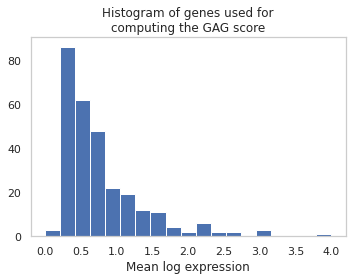

In [12]:
# Mean expression of GAGs
df_plot = dic_model['w_sig50_dir80'].copy()
df_plot['mean'] = dic_data['facs'][:,df_plot.index].X.mean(axis=0).T

bins = np.linspace(0,4,20)
plt.figure(figsize=[5,4])
plt.hist(df_plot['mean'], bins=bins)
plt.grid(linestyle='')
plt.xlabel('Mean log expression')
plt.title('Histogram of genes used for\ncomputing the GAG score')
plt.tight_layout()
plt.savefig(RESULT_PATH+'/fig_aging_score/hist_gag_score_gene.pdf')
plt.show()

In [13]:
# Compute GAG score
start_time = time.time()
dic_score = {x:{} for x in data_list}

# facs data Different models 
dname = 'facs'
for mname in dic_model.keys():
    dic_score[dname][mname] = util.compute_aging_score(dic_data[dname], dic_model[mname],
                                                       flag_correct_background=True, verbose=False)
    print('# data=%s, model=%s'%(dname, mname))
    
# Default model w_sig50_dir80 and tissue_gag, different data, w/wo bc
for dname in data_list:
    for mname in ['w_sig50_dir80', 'tissue_gag']:
        dic_score[dname][mname] = util.compute_aging_score(dic_data[dname], dic_model[mname],
                                                           flag_correct_background=True, verbose=False)
        dic_score[dname][mname+'_nbc'] = util.compute_aging_score(dic_data[dname], dic_model[mname],
                                                                  flag_correct_background=False, verbose=False)
        print('# data=%s, model=%s'%(dname, mname))
print('# finished, time=%0.1fs'%(time.time()-start_time))

/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# data=facs, model=w_sig40_dir80


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# data=facs, model=w_sig50_dir80


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# data=facs, model=w_sig60_dir80


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# data=facs, model=w_sig70_dir80


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# data=facs, model=w_sig80_dir80


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# data=facs, model=w_sig50_dir60


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# data=facs, model=w_sig50_dir70


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# data=facs, model=w_sig50_dir90


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# data=facs, model=uw_sig50_dir80


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# data=facs, model=qw_coef_sig50_dir80


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# data=facs, model=tissue_gag


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# data=facs, model=w_sig50_dir80


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# data=facs, model=tissue_gag


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# data=droplet, model=w_sig50_dir80


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# data=droplet, model=tissue_gag


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# data=bulk, model=w_sig50_dir80


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# data=bulk, model=tissue_gag


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# data=kimmel, model=w_sig50_dir80


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# data=kimmel, model=tissue_gag


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# data=kowalczyk, model=w_sig50_dir80
# data=kowalczyk, model=tissue_gag
# finished, time=247.7s


/home/jz286/myenv/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


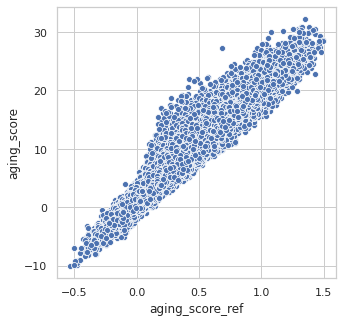

In [14]:
# Compare with previous aging score
df_score1 = dic_score['facs']['w_sig50_dir80'][['score']].copy()
df_score1.columns = ['aging_score']
df_score2 = df_aging_score_old[['score']]
df_score2.columns = ['aging_score_ref']
df_plot = df_score1.copy()
df_plot = df_plot.join(df_score2)

plt.figure(figsize=[5,5])
sns.scatterplot(x='aging_score_ref', y='aging_score', data=df_plot)
plt.show()

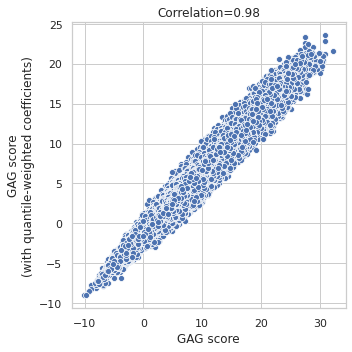

In [15]:
# Compare with quantile-weight
df_score1 = dic_score['facs']['w_sig50_dir80'][['score']].copy()
df_score1.columns = ['aging_score']
df_score2 = dic_score['facs']['qw_coef_sig50_dir80'][['score']].copy()
df_score2.columns = ['aging_score_qw_coef']
df_plot = df_score1.copy()
df_plot = df_plot.join(df_score2)

plt.figure(figsize=[5,5])
sns.scatterplot(x='aging_score', y='aging_score_qw_coef', data=df_plot)
plt.xlabel('GAG score')
plt.ylabel('GAG score\n(with quantile-weighted coefficients)')
plt.title('Correlation=%0.2f'%(np.corrcoef(df_plot['aging_score'], df_plot['aging_score_qw_coef'])[0,1]))
plt.tight_layout()
plt.savefig(RESULT_PATH+'/fig_aging_score/comparision_quantile_weight.pdf')
plt.savefig(RESULT_PATH+'/fig_aging_score/comparision_quantile_weight.jpg')
plt.show()

### Compare GAG scores

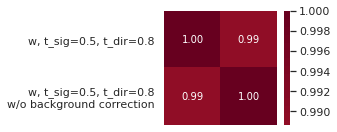

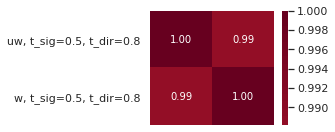

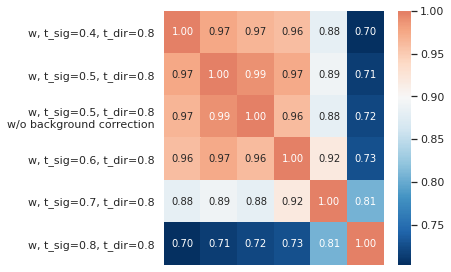

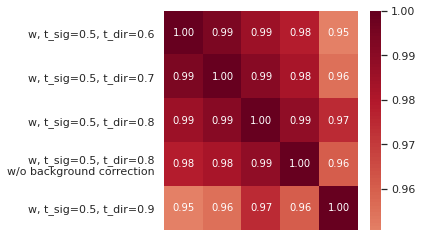

In [16]:
model_list = list(dic_score['facs'].keys())
model_list.sort()
mname_default = 'w_sig50_dir80'
df_plot = pd.DataFrame(index=model_list, columns=model_list, data=0)
for i in np.arange(len(model_list)):
    for j in np.arange(i, len(model_list)):
        model1 = model_list[i]
        model2 = model_list[j]
        corr_ = np.corrcoef(dic_score['facs'][model1]['score'].values, 
                            dic_score['facs'][model2]['score'].values)[0,1]
        df_plot.loc[model1, model2] = corr_
        df_plot.loc[model2, model1] = corr_

def parse_mname(x):
    if x[0]=='w':
        s1='w'
    else:
        s1='uw'
    sig_thres = int(x.split('_')[1].replace('sig',''))/100
    dir_thres = int(x.split('.')[0].split('_')[2].replace('dir',''))/100
    flag_nbc = ('_nbc' in x)
    temp_name = '%s, t_sig=%.1f, t_dir=%.1g'%(s1, sig_thres, dir_thres)
    if flag_nbc:
        temp_name+='\nw/o background correction'
    return temp_name

dic_comparison = {'bc': [mname_default, mname_default+'_nbc'],
                  'w': [mname_default.replace('w_', 'uw_'), mname_default], 
                  'sig': [x for x in model_list if (x[0]=='w') & ('_dir80' in x)],
                  'dir': [x for x in model_list if (x[0]=='w') & ('_sig50' in x)]}
for term in dic_comparison.keys():
    plot_list = dic_comparison[term]
    plt.figure(figsize=[4+0.5*len(plot_list),1+0.5*len(plot_list)])
    sns.heatmap(df_plot.loc[plot_list, plot_list],
                xticklabels=False, yticklabels=True,
                annot=df_plot.loc[plot_list, plot_list], fmt='0.2f',
                cmap = 'RdBu_r', center=0.9, cbar_kws={"shrink": 1})
    plt.yticks(np.arange(len(plot_list))+0.5, [parse_mname(x) for x in plot_list], rotation=0)
    plt.tight_layout(rect=[0.05, 0.03, 0.95, 1])
    plt.savefig(RESULT_PATH+'/fig_aging_score/comparision_%s.pdf'%term)
    plt.show()
#     break

### Overlapping bewteen young and old cells 

/home/jz286/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/jz286/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/jz286/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/jz286/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


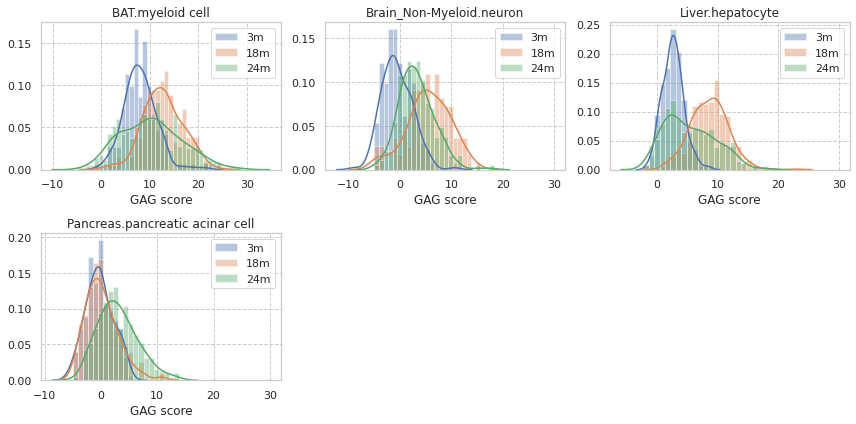

/home/jz286/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/jz286/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/jz286/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/jz286/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/jz286/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:

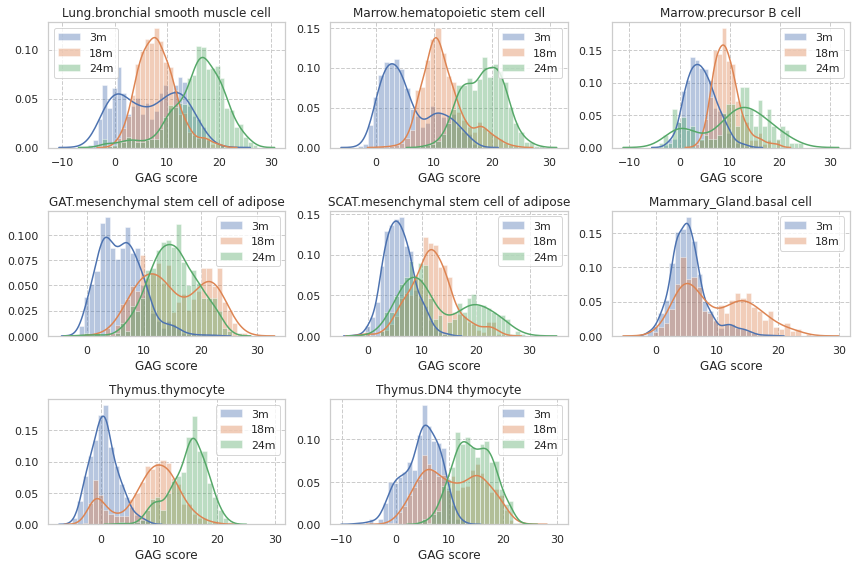

In [17]:
bins_ = np.linspace(-5,30,40)
dname,mname = 'facs','w_sig50_dir80'
age_list = list(set(dic_score[dname][mname]['age_num']))
age_list.sort()

list_yo_look_similar = ['BAT.myeloid cell',
                        'Brain_Non-Myeloid.neuron',
                        'Liver.hepatocyte',
                        'Pancreas.pancreatic acinar cell']

list_bimodal = ['Lung.bronchial smooth muscle cell',
                'Marrow.hematopoietic stem cell',
                'Marrow.precursor B cell',
                'GAT.mesenchymal stem cell of adipose',
                'SCAT.mesenchymal stem cell of adipose',
                'Mammary_Gland.basal cell',
                'Thymus.thymocyte',
                'Thymus.DN4 thymocyte']

list_other = list(set(dic_analysis_list['facs']) - set(list_yo_look_similar) - set(list_bimodal))
list_other.sort()

for i,plot_list in enumerate([list_yo_look_similar, list_bimodal]):
    
    n_plot = len(plot_list)
    plt.figure(figsize=[12, 4+int(n_plot/3)*2])
    
    for i_analyte,analyte in enumerate(plot_list):
        plt.subplot(np.ceil(n_plot/3),3,i_analyte+1)
        temp_df = dic_score[dname][mname].loc[dic_score[dname][mname]['analyte']==analyte]
        for iage,age in enumerate(age_list):
            if (temp_df['age_num']==age).sum()==0:
                continue
            sns.distplot(temp_df.loc[temp_df['age_num']==age, 'score'].values,
                         bins=bins_, color='C%d'%iage, label='%dm'%age)
        plt.legend()
        plt.xlabel('GAG score')
        plt.title(analyte)
        plt.grid(linestyle='--')
    plt.tight_layout()
    plt.savefig(RESULT_PATH+'/fig_aging_score/age_mixed_celltypes_%d.pdf'%i)
    plt.show()

In [18]:
# Would tissue-cell type with more category-specific aging genes be
# more likely to show this heterogenous aging state pattern? 
# temp_df = pd.read_excel('/n/groups/price/martin/tms_gene_data/result_v1/tms_gene_table/tms_gene_table.xlsx')
# temp_df.sum(axis=0)

### Partition GAG score effects 

In [19]:
import statsmodels.api as sm

dic_score_reg = {x:{} for x in data_list}
dic_ols_res = {x:{} for x in data_list}

for mname in ['w_sig50_dir80', 'w_sig50_dir80_nbc']:
    for dname in data_list:
        
        print(dname, mname)

        df_reg = dic_score[dname][mname].copy()
        df_reg['sex_male'] = [1 if x=='male' else 0 for x in df_reg['sex']]

        if len(set(df_reg['sex_male']))>1:
            df_reg = df_reg[['score', 'age_num', 'sex_male', 'analyte']]
        else:
            df_reg = df_reg[['score', 'age_num', 'analyte']]
        df_reg = pd.get_dummies(df_reg, columns=['analyte'], drop_first=False)

        v_y = df_reg['score'].values
        v_y = v_y - v_y.mean()
        
        x_list = [x for x in df_reg.columns if x not in ['score']]
        mat_X = df_reg[x_list].values
        mat_X = mat_X - mat_X.mean(axis=0)
        result = sm.OLS(v_y, mat_X).fit()

        dic_score_reg[dname][mname] = pd.DataFrame(index=x_list)
        dic_score_reg[dname][mname]['mean'] = result.params
        dic_score_reg[dname][mname]['se'] = result.HC0_se
        dic_score_reg[dname][mname]['p'] = result.pvalues
        
        dic_ols_res[dname][mname] = result

facs w_sig50_dir80
droplet w_sig50_dir80
bulk w_sig50_dir80
kimmel w_sig50_dir80
kowalczyk w_sig50_dir80
facs w_sig50_dir80_nbc
droplet w_sig50_dir80_nbc
bulk w_sig50_dir80_nbc
kimmel w_sig50_dir80_nbc
kowalczyk w_sig50_dir80_nbc


In [20]:
# Tissue-level partition
for mname in ['tissue_gag', 'tissue_gag_nbc']:
    for dname in ['facs', 'droplet', 'bulk']:
        
        print(dname, mname)

        df_reg = dic_score[dname][mname].copy()
        df_reg['sex_male'] = [1 if x=='male' else 0 for x in df_reg['sex']]

        if len(set(df_reg['sex_male']))>1:
            df_reg = df_reg[['score', 'age_num', 'sex_male', 'analyte']]
        else:
            df_reg = df_reg[['score', 'age_num', 'analyte']]
        df_reg['analyte'] = [x.split('.')[0] for x in df_reg['analyte']]
        df_reg = pd.get_dummies(df_reg, columns=['analyte'], drop_first=False)

        v_y = df_reg['score'].values
        v_y = v_y - v_y.mean()
        
        x_list = [x for x in df_reg.columns if x not in ['score']]
        mat_X = df_reg[x_list].values
        mat_X = mat_X - mat_X.mean(axis=0)
        result = sm.OLS(v_y, mat_X).fit()

        dic_score_reg[dname][mname] = pd.DataFrame(index=x_list)
        dic_score_reg[dname][mname]['mean'] = result.params
        dic_score_reg[dname][mname]['se'] = result.HC0_se
        dic_score_reg[dname][mname]['p'] = result.pvalues
        
        dic_ols_res[dname][mname] = result

facs tissue_gag
droplet tissue_gag
bulk tissue_gag
facs tissue_gag_nbc
droplet tissue_gag_nbc
bulk tissue_gag_nbc


# w_sig50_dir80, Pearson corr=0.977


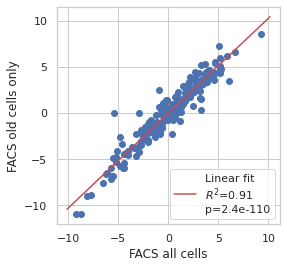

In [21]:
# Partition using only old cells 

mname = 'w_sig50_dir80'
dname = 'facs'
dic_score_reg_old = {x:{} for x in data_list}

df_reg = dic_score[dname][mname].copy()
df_reg['sex_male'] = [1 if x=='male' else 0 for x in df_reg['sex']]

if len(set(df_reg['sex_male']))>1:
    df_reg = df_reg[['score', 'age_num', 'sex_male', 'analyte']]
else:
    df_reg = df_reg[['score', 'age_num', 'analyte']]
df_reg = pd.get_dummies(df_reg, columns=['analyte'], drop_first=False)
df_reg = df_reg.loc[df_reg['age_num']>10]

v_y = df_reg['score'].values
v_y = v_y - v_y.mean()

x_list = [x for x in df_reg.columns if x not in ['score']]
mat_X = df_reg[x_list].values
mat_X = mat_X - mat_X.mean(axis=0)
result = sm.OLS(v_y, mat_X).fit()

dic_score_reg_old[dname][mname] = pd.DataFrame(index=x_list)
dic_score_reg_old[dname][mname]['mean'] = result.params
dic_score_reg_old[dname][mname]['se'] = result.HC0_se
dic_score_reg_old[dname][mname]['p'] = result.pvalues

# Figure
df_plot = dic_score_reg['facs'][mname].copy()
df_plot = df_plot.join(dic_score_reg_old['facs'][mname].copy(), rsuffix='.old_only')
df_plot = df_plot.loc[[x for x in df_plot.index if 'analyte' in x]]

plt.figure(figsize=[4,4])
plt.scatter(df_plot['mean'].values, df_plot['mean.old_only'].values)
# linear fit
sl, icpt, r_val, p_val, _ = sp.stats.linregress(df_plot['mean'], 
                                                df_plot['mean.old_only'])
print('# %s, Pearson corr=%0.3f'%(mname, r_val**0.5))
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
         label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
plt.legend(loc='lower right')

plt.ylabel('FACS old cells only')
plt.xlabel('FACS all cells')
plt.savefig(RESULT_PATH + '/fig_aging_score/compare_facs_old_only.%s.pdf'%mname,
            transparent=True, bbox_inches='tight')
plt.show()

In [22]:
# Other fitting models
# Partition with only age and sex
mname = 'w_sig50_dir80'
# dname = 'facs'
dic_score_reg_no_ct = {x:{} for x in data_list}
dic_ols_res_no_ct = {x:{} for x in data_list}

for dname in data_list:
    df_reg = dic_score[dname][mname].copy()
    df_reg['sex_male'] = [1 if x=='male' else 0 for x in df_reg['sex']]

    if len(set(df_reg['sex_male']))>1:
        df_reg = df_reg[['score', 'age_num', 'sex_male']]
    else:
        df_reg = df_reg[['score', 'age_num']]

    v_y = df_reg['score'].values
    v_y = v_y - v_y.mean()

    x_list = [x for x in df_reg.columns if x not in ['score']]
    mat_X = df_reg[x_list].values
    mat_X = mat_X - mat_X.mean(axis=0)

    result = sm.OLS(v_y, mat_X).fit()
    
    dic_score_reg_no_ct[dname][mname] = pd.DataFrame(index=x_list)
    dic_score_reg_no_ct[dname][mname]['mean'] = result.params
    dic_score_reg_no_ct[dname][mname]['se'] = result.HC0_se
    dic_score_reg_no_ct[dname][mname]['p'] = result.pvalues
    dic_ols_res_no_ct[dname][mname] = result
    
# Partition with age x celltype interaction term 
mname = 'w_sig50_dir80'
dic_score_reg_interaction = {x:{} for x in data_list}
dic_ols_res_interaction = {x:{} for x in data_list}

for dname in data_list:
    df_reg = dic_score[dname][mname].copy()
    df_reg['sex_male'] = [1 if x=='male' else 0 for x in df_reg['sex']]

    if len(set(df_reg['sex_male']))>1:
        df_reg = df_reg[['score', 'age_num', 'sex_male', 'analyte']]
    else:
        df_reg = df_reg[['score', 'age_num', 'analyte']]
    df_reg = pd.get_dummies(df_reg, columns=['analyte'], drop_first=False)

    # Add interaction term
    analyte_list = [x for x in df_reg if 'analyte' in x]
    for analyte in analyte_list:
        temp_v =  df_reg['age_num'].values * df_reg[analyte].values
        if len(set(temp_v))>1:
            df_reg['age.%s'%analyte] = temp_v

    v_y = df_reg['score'].values
    v_y = v_y - v_y.mean()

    x_list = [x for x in df_reg.columns if x not in ['score', 'age.%s'%analyte_list[0]]]
    mat_X = df_reg[x_list].values
    mat_X = mat_X - mat_X.mean(axis=0)

    result = sm.OLS(v_y, mat_X).fit()
    
    dic_score_reg_interaction[dname][mname] = pd.DataFrame(index=x_list)
    dic_score_reg_interaction[dname][mname]['mean'] = result.params
    dic_score_reg_interaction[dname][mname]['se'] = result.HC0_se
    dic_score_reg_interaction[dname][mname]['p'] = result.pvalues
    dic_ols_res_interaction[dname][mname] = result

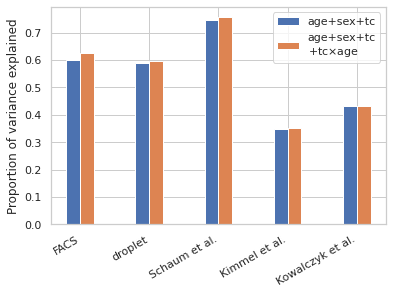

In [23]:
# Proportion explained 
mname = 'w_sig50_dir80'
df_plot = pd.DataFrame(index=data_list, columns=['age+sex', 'age+sex+tc', 'age+sex+tc+tc.age'])
for dname in data_list:
    df_plot.loc[dname, 'age+sex'] = dic_ols_res_no_ct[dname][mname].rsquared
    df_plot.loc[dname, 'age+sex+tc'] = dic_ols_res[dname][mname].rsquared
    df_plot.loc[dname, 'age+sex+tc+tc.age'] = dic_ols_res_interaction[dname][mname].rsquared
df_plot['loc'] = range(df_plot.shape[0])
df_plot['dname'] = [dic_data_name[x] for x in df_plot.index]
    
plt.figure()
# plt.bar(df_plot['loc']-0.2, df_plot['age+sex'], width=0.2, label='age+sex')
plt.bar(df_plot['loc']-0.1, df_plot['age+sex+tc'], width=0.2, label='age+sex+tc')
plt.bar(df_plot['loc']+0.1, df_plot['age+sex+tc+tc.age'], width=0.2, label='age+sex+tc\n'+r'+tc$\times$age')
plt.xticks(df_plot['loc'], df_plot['dname'], rotation=30, ha='right')
plt.legend()
plt.ylabel('Proportion of variance explained')
plt.savefig(RESULT_PATH + '/fig_aging_score/variance_explained.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

In [24]:
df_plot

,age+sex,age+sex+tc,age+sex+tc+tc.age,loc,dname
facs,0.388883,0.60209,0.626359,0,FACS
droplet,0.0120665,0.587722,0.597281,1,droplet
bulk,0.0101911,0.745852,0.756552,2,Schaum et al.
kimmel,0.0357666,0.349299,0.352391,3,Kimmel et al.
kowalczyk,0.345168,0.431041,0.433078,4,Kowalczyk et al.


### GAG score effects: age_num and sex_male

w_sig50_dir80 facs 0.0
w_sig50_dir80 droplet 0.0
w_sig50_dir80 bulk 6.868263784396213e-10
w_sig50_dir80 kimmel 0.0
w_sig50_dir80 kowalczyk 3.752363489323026e-133


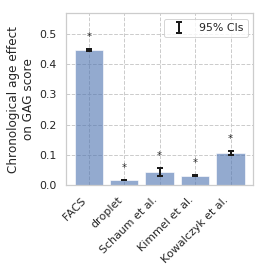

w_sig50_dir80_nbc facs 0.0
w_sig50_dir80_nbc droplet 3.7964262317976586e-266
w_sig50_dir80_nbc bulk 5.189616991452427e-13
w_sig50_dir80_nbc kimmel 0.0
w_sig50_dir80_nbc kowalczyk 9.269758695893871e-130


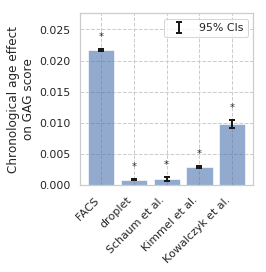

In [19]:
# age_num
for mname in ['w_sig50_dir80', 'w_sig50_dir80_nbc']:
    df_plot = pd.DataFrame(index=data_list, columns=['mean', 'se', 'p'], data=0)
    for dname in data_list:
        df_plot.loc[dname] = dic_score_reg[dname][mname].loc['age_num', ['mean', 'se', 'p']]
        print(mname, dname, df_plot.loc[dname, 'p'])
    df_plot['loc'] = np.arange(df_plot.shape[0])

    plt.figure(figsize=[4,4])
    plt.bar(df_plot['loc'], df_plot['mean'], alpha=0.6, color='C0')

    plt.errorbar(df_plot['loc'], df_plot['mean'], yerr=1.96*df_plot['se'],
                 fmt='none', color='k', label='95% CIs', 
                 elinewidth=2, capsize=3, capthick=2)
    util.label_bar(df_plot['p'].values, df_plot['loc'].values,
                   df_plot['mean'].values+1.96*df_plot['se'].values)

    plt.ylabel('Chronological age effect\non GAG score')
    plt.xticks(df_plot['loc'], [dic_data_name[x] for x in df_plot.index], rotation=45, ha='right')
    plt.grid(True, linestyle='--')
    plt.tight_layout(rect=[0.05, 0.03, 1, 1])
    plt.legend(loc='upper right')
    plt.savefig(RESULT_PATH+'/fig_aging_score/score_cage.%s.%s.pdf'%(mname,dname))
    plt.show()


### Tissue-cell-type GAG effects

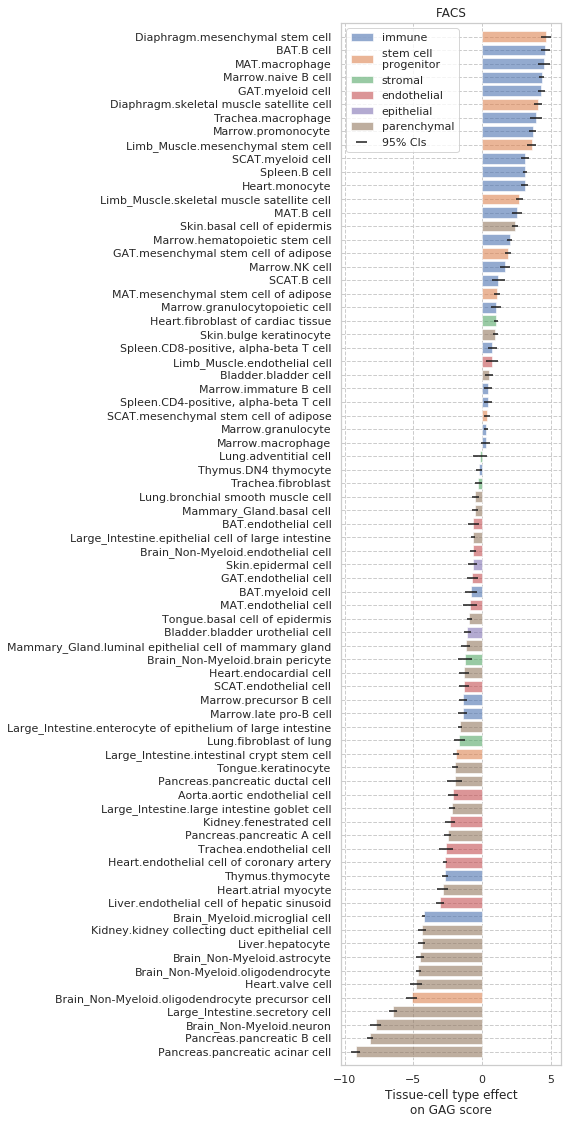

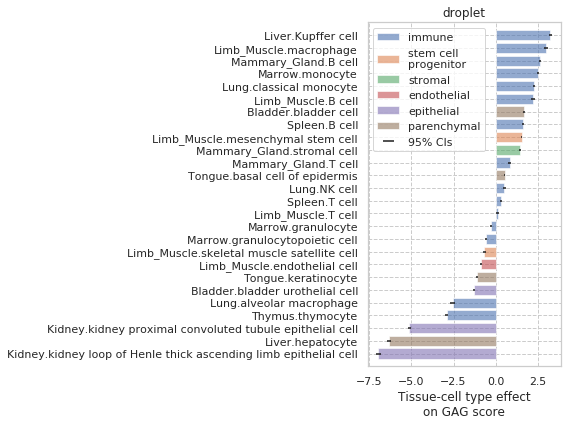

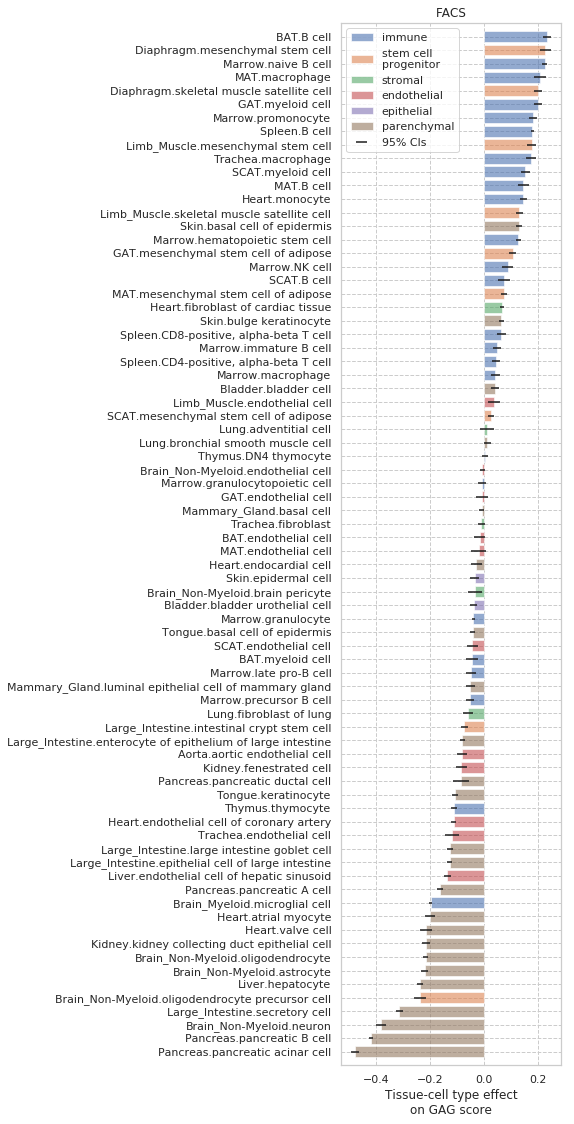

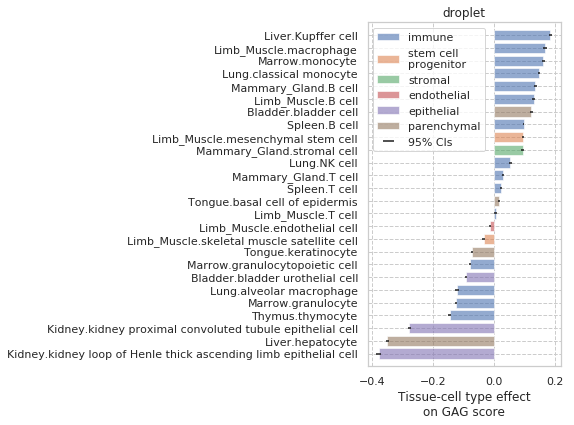

In [20]:
# facs and droplet data 
for mname in ['w_sig50_dir80', 'w_sig50_dir80_nbc']:
    for dname in ['facs', 'droplet']:

        df_plot = dic_score_reg[dname][mname].copy()
        df_plot.index = [x.replace('analyte_', '') for x in df_plot.index]
        df_plot.columns = ['reg.mean', 'reg.se', 'reg.p']
        df_plot = df_plot.loc[dic_analysis_list[dname]]

        df_plot = df_plot.sort_values(by='reg.mean')
        df_plot['analyte'] = df_plot.index
        df_plot['loc'] = np.arange(df_plot.shape[0])
        df_plot = df_plot.join(dic_anno[dname][['cell category', 'binary_lifespan']])

        plt.figure(figsize=[8.5, 1 + 0.2*df_plot.shape[0]])
        y_min,y_max = -1, df_plot.shape[0]
        for i_cellcate,cellcate in enumerate(CELLCATE_LIST):
            ind_select = [cellcate in x.split(';')[0] for x in df_plot['cell category']]
            plt.barh(df_plot.loc[ind_select, 'loc'], 
                     df_plot.loc[ind_select, 'reg.mean'], 
                     alpha=0.6, color='C%d'%i_cellcate, label=cellcate.replace('/', '\n'))

        plt.errorbar(df_plot['reg.mean'], df_plot['loc'], xerr=1.96*df_plot['reg.se'],
                     fmt='none', color='k', label='95% CIs')

        plt.ylim([y_min, y_max])
        plt.xlabel('Tissue-cell type effect\non GAG score')

        plt.yticks(df_plot['loc'], df_plot['analyte'])
        plt.grid(True, linestyle='--')
        plt.title(dic_data_name[dname])
        plt.tight_layout(rect=[0.05, 0.03, 1, 1])
        plt.legend(loc='upper left')
        plt.savefig(RESULT_PATH+'/fig_aging_score/score_celltype_effect.%s.%s.pdf'%(mname,dname))
        plt.show()

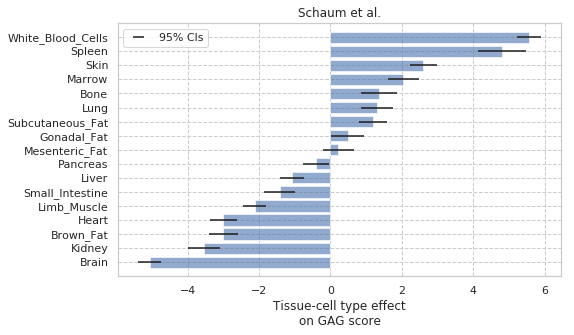

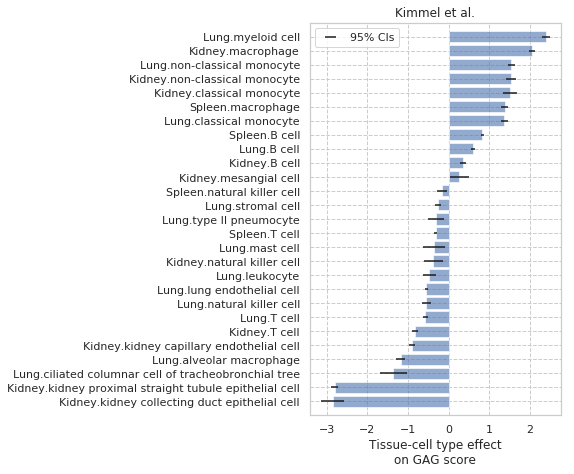

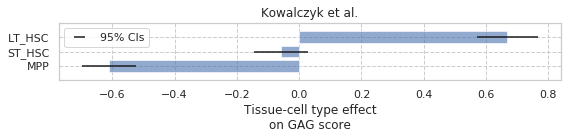

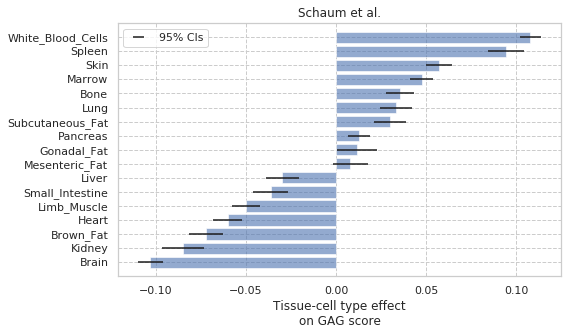

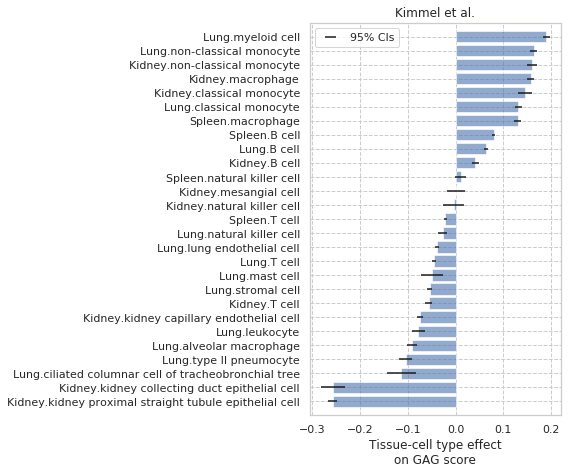

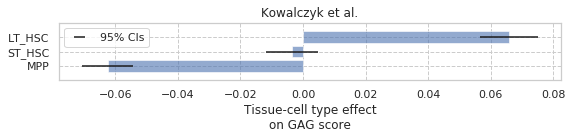

In [28]:
# other data

for mname in ['w_sig50_dir80', 'w_sig50_dir80_nbc']:
    for dname in ['bulk', 'kimmel', 'kowalczyk']:
        
        df_plot = dic_score_reg[dname][mname].copy()
        df_plot.index = [x.replace('analyte_', '') for x in df_plot.index]
        df_plot.columns = ['reg.mean', 'reg.se', 'reg.p']

        df_plot = df_plot.loc[[x for x in df_plot.index if x.split('_')[0] not in ['sex', 'age']]]

        df_plot = df_plot.sort_values(by='reg.mean')
        df_plot['analyte'] = df_plot.index
        df_plot['loc'] = np.arange(df_plot.shape[0])

        plt.figure(figsize=[8.5, 1.5 + 0.2*df_plot.shape[0]])
        y_min,y_max = -1, df_plot.shape[0]
        plt.barh(df_plot['loc'],df_plot['reg.mean'], alpha=0.6, color='C0')

        plt.errorbar(df_plot['reg.mean'], df_plot['loc'], xerr=1.96*df_plot['reg.se'],
                     fmt='none', color='k', label='95% CIs')

        plt.ylim([y_min, y_max])
        plt.xlabel('Tissue-cell type effect\non GAG score')

        plt.yticks(df_plot['loc'], df_plot['analyte'])
        plt.grid(True, linestyle='--')
        plt.title(dic_data_name[dname])
        plt.tight_layout(rect=[0.05, 0.03, 1, 1])
        plt.legend()
        plt.savefig(RESULT_PATH+'/fig_aging_score/score_celltype_effect.%s.%s.pdf'%(mname,dname))
        plt.show()


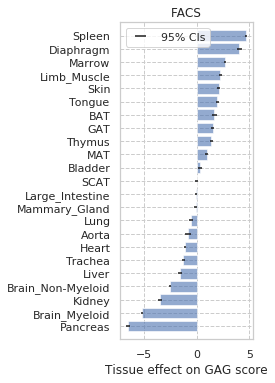

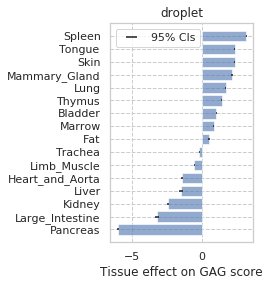

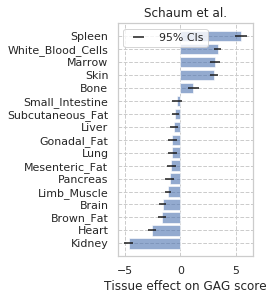

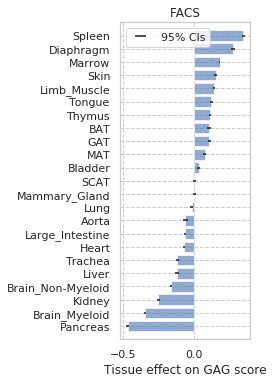

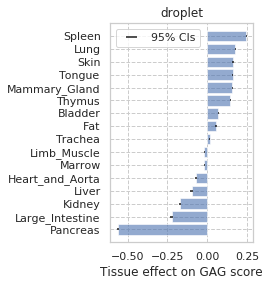

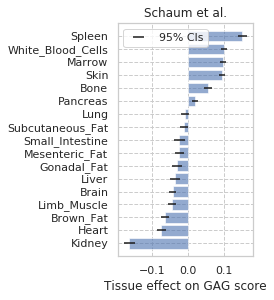

In [22]:
# facs aging score (regress out age and sex)
for mname in ['tissue_gag', 'tissue_gag_nbc']:
    for dname in ['facs', 'droplet', 'bulk']:

        df_plot = dic_score_reg[dname][mname].copy()
        df_plot.index = [x.replace('analyte_', '') for x in df_plot.index]
        df_plot.columns = ['reg.mean', 'reg.se', 'reg.p']
        df_plot = df_plot.drop(labels=['age_num', 'sex_male'], axis=0)

        df_plot = df_plot.sort_values(by='reg.mean')
        df_plot['analyte'] = df_plot.index
        df_plot['loc'] = np.arange(df_plot.shape[0])

        plt.figure(figsize=[4, 1 + 0.2*df_plot.shape[0]])
        y_min,y_max = -1, df_plot.shape[0]
        plt.barh(df_plot['loc'],df_plot['reg.mean'], alpha=0.6, color='C0')
        
        plt.errorbar(df_plot['reg.mean'], df_plot['loc'], xerr=1.96*df_plot['reg.se'],
                     fmt='none', color='k', label='95% CIs')

        plt.ylim([y_min, y_max])
        plt.xlabel('Tissue effect on GAG score')

        plt.yticks(df_plot['loc'], df_plot['analyte'])
        plt.grid(True, linestyle='--')
        plt.title(dic_data_name[dname])
        plt.tight_layout(rect=[0.05, 0.03, 1, 1])
        plt.legend(loc='upper left')
        plt.savefig(RESULT_PATH+'/fig_aging_score/score_celltype_effect.%s.%s.pdf'%(mname,dname))
        plt.show()

### Comparing different datasets

# w_sig50_dir80, Pearson corr=0.872


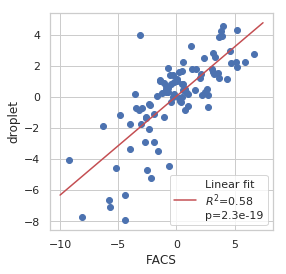

# w_sig50_dir80_nbc, Pearson corr=0.872


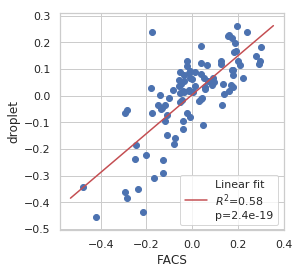

# tissue_gag, Pearson corr=0.900


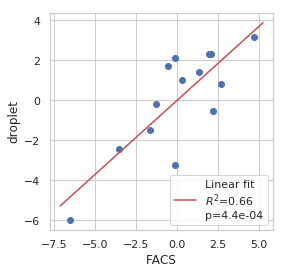

# tissue_gag_nbc, Pearson corr=0.909


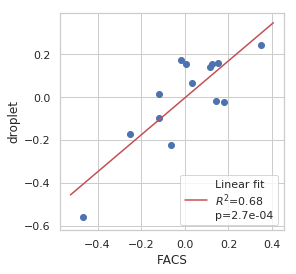

In [23]:
for mname in ['w_sig50_dir80', 'w_sig50_dir80_nbc', 'tissue_gag', 'tissue_gag_nbc']:
    df_plot = dic_score_reg['facs'][mname].copy()
    df_plot = df_plot.join(dic_score_reg['droplet'][mname].copy(), rsuffix='.droplet')
    df_plot = df_plot.loc[~np.isnan(df_plot['mean.droplet'])]
    df_plot = df_plot.loc[[x for x in df_plot.index if 'analyte' in x]]

    plt.figure(figsize=[4,4])
    plt.scatter(df_plot['mean'].values, df_plot['mean.droplet'].values)
    # linear fit
    sl, icpt, r_val, p_val, _ = sp.stats.linregress(df_plot['mean'], 
                                                    df_plot['mean.droplet'])
    print('# %s, Pearson corr=%0.3f'%(mname, r_val**0.5))
    x_min,x_max = plt.xlim()
    y_min,y_max = plt.ylim()
    plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
             label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
    plt.legend(loc='lower right')

    plt.ylabel(dic_data_name['droplet'])
    plt.xlabel(dic_data_name['facs'])
    plt.savefig(RESULT_PATH + '/fig_aging_score/compare_facs_droplet.%s.pdf'%mname,
                transparent=True, bbox_inches='tight')
    plt.show()

# w_sig50_dir80, Pearson corr=0.870


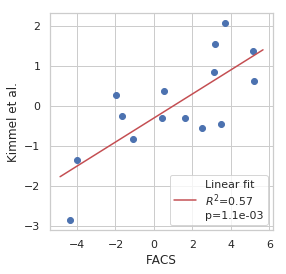

# w_sig50_dir80_nbc, Pearson corr=0.828


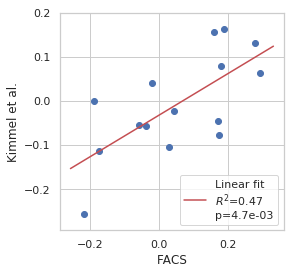

In [24]:
def update_tissue(x):
    x = x.replace('analyte_Spleen.T cell', 'analyte_Spleen.CD4-positive, alpha-beta T cell')
    x = x.replace('analyte_Lung.stromal cell', 'analyte_Lung.fibroblast of lung')
    return x 

for mname in ['w_sig50_dir80', 'w_sig50_dir80_nbc']:
    df_plot = dic_score_reg['facs'][mname].copy()
    temp_df = dic_score_reg['kimmel'][mname].copy()
    temp_df.index = [update_tissue(x) for x in temp_df.index]
    df_plot = df_plot.join(temp_df.copy(), rsuffix='.kimmel')
    df_plot = df_plot.loc[~np.isnan(df_plot['mean.kimmel'])]
    df_plot = df_plot.loc[[x for x in df_plot.index if 'analyte' in x]]

    plt.figure(figsize=[4,4])
    plt.scatter(df_plot['mean'].values, df_plot['mean.kimmel'].values)
    # linear fit
    sl, icpt, r_val, p_val, _ = sp.stats.linregress(df_plot['mean'], 
                                                    df_plot['mean.kimmel'])
    print('# %s, Pearson corr=%0.3f'%(mname, r_val**0.5))
    x_min,x_max = plt.xlim()
    y_min,y_max = plt.ylim()
    plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
             label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
    plt.legend(loc='lower right')

    plt.ylabel(dic_data_name['kimmel'])
    plt.xlabel(dic_data_name['facs'])
    plt.savefig(RESULT_PATH + '/fig_aging_score/compare_facs_kimmel.%s.pdf'%mname,
                transparent=True, bbox_inches='tight')
    plt.show()

# tissue_gag, Pearson corr=0.858


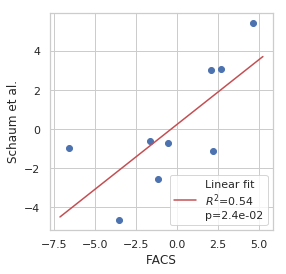

# tissue_gag_nbc, Pearson corr=0.785


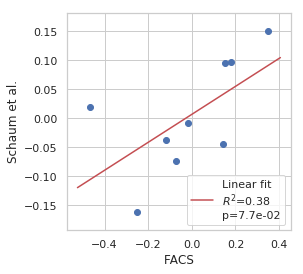

In [25]:
for mname in ['tissue_gag', 'tissue_gag_nbc']:
    df_plot = dic_score_reg['facs'][mname].copy()
    df_plot = df_plot.join(dic_score_reg['bulk'][mname].copy(), rsuffix='.bulk')
    df_plot = df_plot.loc[~np.isnan(df_plot['mean.bulk'])]
    df_plot = df_plot.loc[[x for x in df_plot.index if 'analyte' in x]]

    plt.figure(figsize=[4,4])
    plt.scatter(df_plot['mean'].values, df_plot['mean.bulk'].values)
    # linear fit
    sl, icpt, r_val, p_val, _ = sp.stats.linregress(df_plot['mean'], df_plot['mean.bulk'])
    print('# %s, Pearson corr=%0.3f'%(mname, r_val**0.5))
    x_min,x_max = plt.xlim()
    y_min,y_max = plt.ylim()
    plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
             label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
    plt.legend(loc='lower right')

    plt.ylabel(dic_data_name['bulk'])
    plt.xlabel(dic_data_name['facs'])
    plt.savefig(RESULT_PATH + '/fig_aging_score/compare_facs_bulk.%s.pdf'%mname,
                transparent=True, bbox_inches='tight')
    plt.show()

### Celltype score by functional category and lifespan

w_sig50_dir80 facs


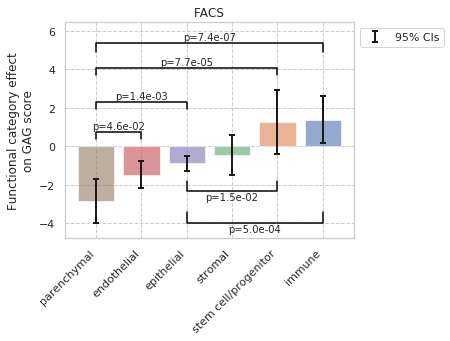

w_sig50_dir80 droplet


../util.py:362: RuntimeWarning: invalid value encountered in double_scalars
  tau2 = np.maximum(0, (Q-df) / (vwts.sum() - vwts.dot(vwts) / vwts.sum()))
../util.py:378: RuntimeWarning: invalid value encountered in double_scalars
  varsum = np.sum(wt*wt*(variances+tau2)) / (np.sum(wt)**2)


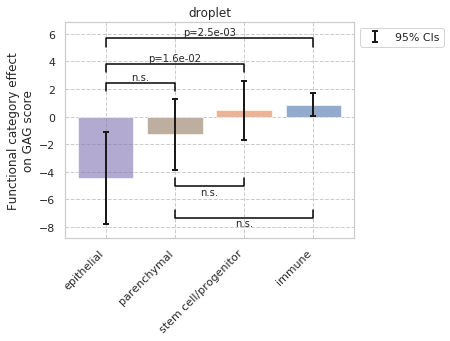

w_sig50_dir80_nbc facs


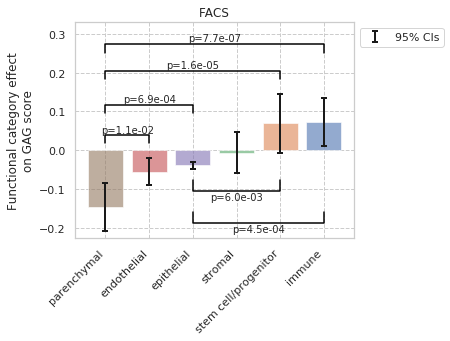

w_sig50_dir80_nbc droplet


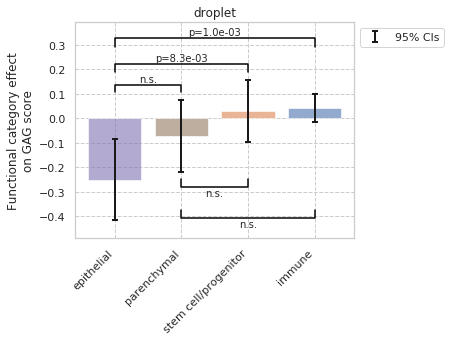

In [26]:
# functional category

for mname in ['w_sig50_dir80', 'w_sig50_dir80_nbc']:
    for dname in ['facs', 'droplet']:
        
        print(mname, dname)
        
        df_plot = dic_score_reg[dname][mname].copy()
        df_plot.index = [x.replace('analyte_', '') for x in df_plot.index]
        df_plot.columns = ['reg.mean', 'reg.se', 'reg.p']
        if dname in dic_analysis_list.keys():
            df_plot = df_plot.loc[dic_analysis_list[dname]]
        df_plot = df_plot.join(dic_anno[dname][['cell category', 'binary_lifespan']])

        temp_df = pd.DataFrame(index=CELLCATE_LIST, columns=['mean', 'se'], dtype=float)
        for i_cellcate,cellcate in enumerate(CELLCATE_LIST):
            ind_select = [cellcate in x.split(';')[0] for x in df_plot['cell category']]
            mean_,se_=util.meta_analysis(df_plot.loc[ind_select, 'reg.mean'],
                                         df_plot.loc[ind_select, 'reg.se'])
            temp_df.loc[cellcate] = [mean_,se_]

        df_plot = temp_df.copy()
        df_plot = df_plot.loc[~np.isnan(df_plot['mean'].values)]
        df_plot = df_plot.sort_values(by='mean')
        df_plot['loc'] = np.arange(df_plot.shape[0])

        plt.figure(figsize=[8,5])
        y_min,y_max = -1, df_plot.shape[0]

        for i_cellcate,cellcate in enumerate(CELLCATE_LIST):
            ind_select = (df_plot.index==cellcate)
            plt.bar(df_plot.loc[ind_select, 'loc'], df_plot.loc[ind_select, 'mean'], 
                    alpha=0.6, color='C%d'%i_cellcate)

        plt.errorbar(df_plot['loc'], df_plot['mean'], yerr=1.96*df_plot['se'],
                     fmt='none', color='k', label='95% CIs', 
                     elinewidth=2, capsize=3, capthick=2)

        # Add significance 
        if dname=='facs':
            plot_list = [['parenchymal', 'endothelial', .05, 'upper'],
                         ['parenchymal', 'epithelial', .25, 'upper'],
                         ['parenchymal', 'stem cell/progenitor', .1, 'upper'],
                         ['parenchymal', 'immune', .25, 'upper'],                     
                         ['epithelial', 'stem cell/progenitor', .05, 'lower'],
                         ['epithelial', 'immune', .2, 'lower']]
        elif dname=='droplet': 
            plot_list = [['epithelial', 'parenchymal', .05, 'upper'],
                         ['parenchymal', 'stem cell/progenitor', .05, 'lower'],
                         ['parenchymal', 'immune', .25, 'lower'],
                         ['epithelial', 'stem cell/progenitor', .05, 'upper'],
                         ['epithelial', 'immune', .25, 'upper']]
        else:
            plot_list = []

        for ip,p in enumerate(plot_list):
            p_val = util.get_p_two_point(df_plot.loc[p[0], 'mean'], df_plot.loc[p[0], 'se'], 
                                         df_plot.loc[p[1], 'mean'], df_plot.loc[p[1], 'se'])
            if p[3]=='upper':
                ymax = max([df_plot.loc[p[0],'mean']+1.96*df_plot.loc[p[0],'se'],
                            df_plot.loc[p[1],'mean']+1.96*df_plot.loc[p[1],'se'], 0])
            else:
                ymax = min([df_plot.loc[p[0],'mean']-1.96*df_plot.loc[p[0],'se'],
                            df_plot.loc[p[1],'mean']-1.96*df_plot.loc[p[1],'se'], 0])
            text='p=%0.1e'%p_val if p_val<0.05 else 'n.s.'
            util.label_bardif(text, df_plot.loc[p[0], 'loc'], df_plot.loc[p[1], 'loc'],
                              ymax, ymax, dh=p[2], loc=p[3])

        plt.ylabel('Functional category effect\non GAG score')
        plt.xticks(df_plot['loc'], df_plot.index, rotation=45, ha='right')
        plt.grid(True, linestyle='--')
        plt.title(dic_data_name[dname])
        plt.tight_layout(rect=[0.05, 0.03, 0.7, 1])
        plt.legend(loc="upper left", bbox_to_anchor=(1,1))
        plt.savefig(RESULT_PATH+'/fig_aging_score/score_cellcate.%s.%s.pdf'%(mname,dname))
        plt.show()
#         break 

w_sig50_dir80 facs
short 10 ['Heart.monocyte', 'Large_Intestine.enterocyte of epithelium of large intestine', 'Marrow.NK cell', 'Marrow.granulocyte', 'Marrow.hematopoietic stem cell', 'Skin.epidermal cell', 'Spleen.B cell', 'Spleen.CD4-positive, alpha-beta T cell', 'Spleen.CD8-positive, alpha-beta T cell', 'Thymus.thymocyte']
long 18 ['Aorta.aortic endothelial cell', 'Bladder.bladder cell', 'Bladder.bladder urothelial cell', 'Brain_Myeloid.microglial cell', 'Brain_Non-Myeloid.endothelial cell', 'Brain_Non-Myeloid.neuron', 'Brain_Non-Myeloid.oligodendrocyte', 'Heart.atrial myocyte', 'Heart.endocardial cell', 'Heart.endothelial cell of coronary artery', 'Heart.fibroblast of cardiac tissue', 'Limb_Muscle.endothelial cell', 'Liver.hepatocyte', 'Lung.fibroblast of lung', 'Pancreas.pancreatic A cell', 'Pancreas.pancreatic B cell', 'Pancreas.pancreatic ductal cell', 'Skin.basal cell of epidermis']


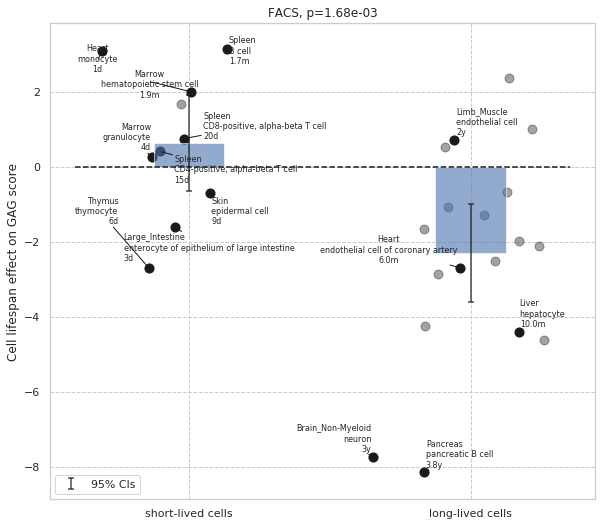

w_sig50_dir80 droplet
short 9 ['Limb_Muscle.T cell', 'Lung.NK cell', 'Lung.classical monocyte', 'Mammary_Gland.T cell', 'Marrow.granulocyte', 'Marrow.monocyte', 'Spleen.B cell', 'Spleen.T cell', 'Thymus.thymocyte']
long 4 ['Bladder.bladder cell', 'Bladder.bladder urothelial cell', 'Limb_Muscle.endothelial cell', 'Liver.hepatocyte']


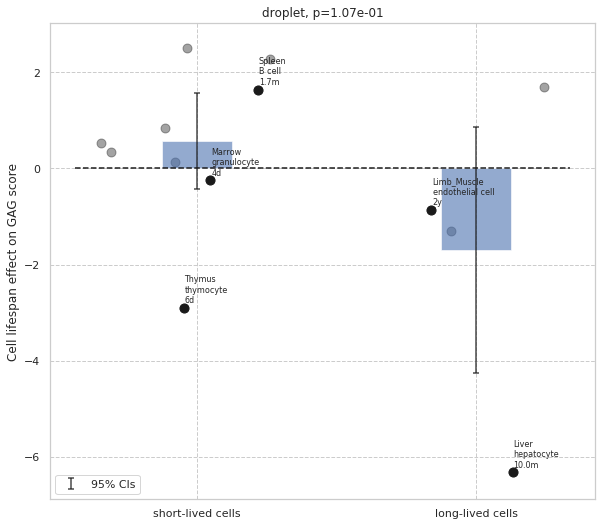

w_sig50_dir80_nbc facs
short 10 ['Heart.monocyte', 'Large_Intestine.enterocyte of epithelium of large intestine', 'Marrow.NK cell', 'Marrow.granulocyte', 'Marrow.hematopoietic stem cell', 'Skin.epidermal cell', 'Spleen.B cell', 'Spleen.CD4-positive, alpha-beta T cell', 'Spleen.CD8-positive, alpha-beta T cell', 'Thymus.thymocyte']
long 18 ['Aorta.aortic endothelial cell', 'Bladder.bladder cell', 'Bladder.bladder urothelial cell', 'Brain_Myeloid.microglial cell', 'Brain_Non-Myeloid.endothelial cell', 'Brain_Non-Myeloid.neuron', 'Brain_Non-Myeloid.oligodendrocyte', 'Heart.atrial myocyte', 'Heart.endocardial cell', 'Heart.endothelial cell of coronary artery', 'Heart.fibroblast of cardiac tissue', 'Limb_Muscle.endothelial cell', 'Liver.hepatocyte', 'Lung.fibroblast of lung', 'Pancreas.pancreatic A cell', 'Pancreas.pancreatic B cell', 'Pancreas.pancreatic ductal cell', 'Skin.basal cell of epidermis']


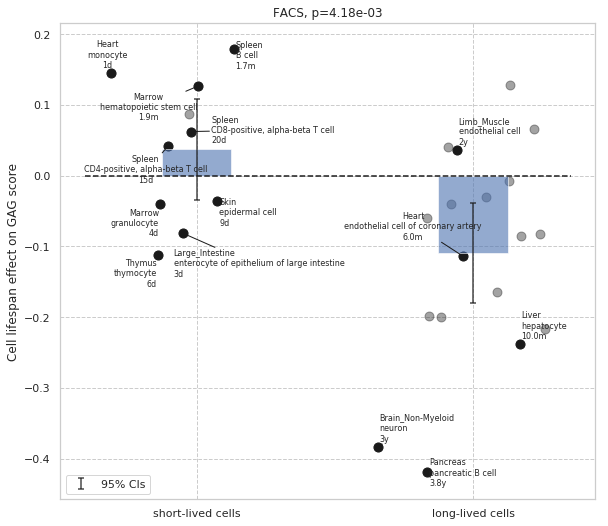

w_sig50_dir80_nbc droplet
short 9 ['Limb_Muscle.T cell', 'Lung.NK cell', 'Lung.classical monocyte', 'Mammary_Gland.T cell', 'Marrow.granulocyte', 'Marrow.monocyte', 'Spleen.B cell', 'Spleen.T cell', 'Thymus.thymocyte']
long 4 ['Bladder.bladder cell', 'Bladder.bladder urothelial cell', 'Limb_Muscle.endothelial cell', 'Liver.hepatocyte']


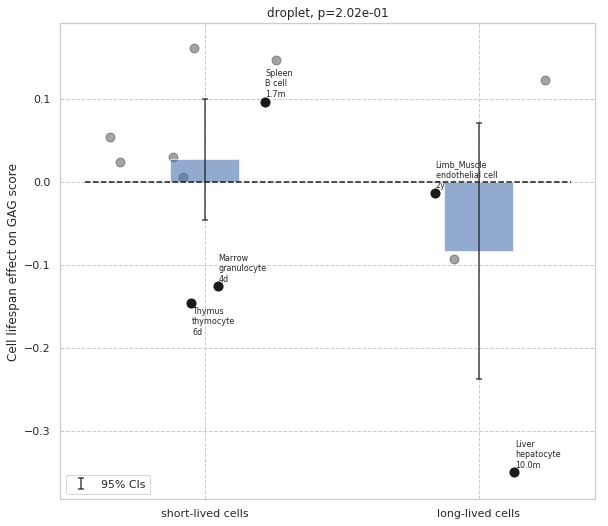

In [27]:
# binary lifespan

annot_list = ['Brain_Non-Myeloid.neuron',
              'Heart.endothelial cell of coronary artery',
              'Heart.monocyte',
              'Large_Intestine.enterocyte of epithelium of large intestine',
              'Limb_Muscle.endothelial cell',
              'Liver.hepatocyte',
              'Marrow.granulocyte',
              'Marrow.hematopoietic stem cell',
              'Pancreas.pancreatic B cell',
              'Skin.epidermal cell',
              'Spleen.B cell',
              'Spleen.CD4-positive, alpha-beta T cell',
              'Spleen.CD8-positive, alpha-beta T cell',
              'Thymus.thymocyte']

def update_name(x):
    x_num = int(x[:-1])
    if x[-1]=='d':
        if x_num>=360:
            return '%0.1fy'%(x_num/365)
        elif x_num>=30:
            return '%0.1fm'%(x_num/30)
        else:
            return '%dd'%x_num
    else:
        return x

for mname in ['w_sig50_dir80', 'w_sig50_dir80_nbc']:
    for dname in ['facs', 'droplet']:
        
        print(mname, dname)
        
        df_plot = dic_score_reg[dname][mname].copy()
        df_plot.index = [x.replace('analyte_', '') for x in df_plot.index]
        df_plot.columns = ['reg.mean', 'reg.se', 'reg.p']
        if dname in dic_analysis_list.keys():
            df_plot = df_plot.loc[dic_analysis_list[dname]]
        df_plot = df_plot.join(dic_anno[dname][['cell category', 'binary_lifespan', 'turnover_mouse']])
        df_plot = df_plot.loc[[x in ['short', 'long'] for x in df_plot['binary_lifespan']]]

        temp_df = pd.DataFrame(index=['short', 'long'], columns=['mean', 'se'], dtype=float)
        for term in ['short', 'long']:
            ind_select = df_plot['binary_lifespan']==term
            print(term, ind_select.sum(), list(df_plot.index[ind_select]))
            mean_,se_=util.meta_analysis(df_plot.loc[ind_select, 'reg.mean'],
                                         df_plot.loc[ind_select, 'reg.se'])
            temp_df.loc[term] = [mean_,se_]

        df_plot_meta = temp_df.copy()
        df_plot_meta['loc'] = np.arange(df_plot_meta.shape[0])
        
        plt.figure(figsize=[9,7.5])
        y_min,y_max = -1, df_plot_meta.shape[0]

        plt.bar(df_plot_meta['loc'], df_plot_meta['mean'], alpha=0.6, color='C0', width=0.25)
        plt.errorbar(df_plot_meta['loc'], df_plot_meta['mean'], yerr=1.96*df_plot_meta['se'],
                     fmt='none', color='k', label='95% CIs', 
                     elinewidth=2, capsize=3, capthick=2, alpha=0.6)
        
        # Add scatter
        np.random.seed(1)
        temp_annot_list = list(set(annot_list)&set(df_plot.index))
        df_plot['loc'] = (df_plot['binary_lifespan']=='long') + np.random.randn(df_plot.shape[0])*0.15
        plt.scatter(df_plot['loc'], df_plot['reg.mean'], label=None, color='k', alpha=0.4, s=80)
        plt.scatter(df_plot.loc[temp_annot_list, 'loc'], df_plot.loc[temp_annot_list, 'reg.mean'],
                    label=None, color='k', alpha=1, s=80)
        texts = []
        for analyte in temp_annot_list:
            texts.append(plt.text(df_plot.loc[analyte, 'loc'], df_plot.loc[analyte,'reg.mean'],
                                  '%s\n%s\n%s'%(analyte.split('.')[0],analyte.split('.')[1],
                                                update_name(df_plot.loc[analyte, 'turnover_mouse'])),
                                  fontsize=8, zorder=10))
        adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))
        
        xmin_,xmax_ = plt.xlim()
        plt.plot([xmin_,xmax_],[0,0], linestyle='--', color='k')

        plt.ylabel('Cell lifespan effect on GAG score')

        plt.xticks(df_plot_meta['loc'], ['%s-lived cells'%x for x in df_plot_meta.index],
                   rotation=0, ha='center')
        plt.grid(True, linestyle='--')
        plt.tight_layout(rect=[0.05, 0.03, 1, 1])
        plt.legend(loc='lower left')
        p_val = util.get_p_two_point(df_plot_meta.loc['short', 'mean'], df_plot_meta.loc['short', 'se'], 
                                     df_plot_meta.loc['long', 'mean'], df_plot_meta.loc['long', 'se'])
        plt.title('%s, p=%0.2e'%(dic_data_name[dname], p_val))
        plt.savefig(RESULT_PATH+'/fig_aging_score/score_lifespan.%s.%s.pdf'%(mname,dname))
        plt.show()
#         break
#     break